In [1]:
#importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import random
import gc
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import timm
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

# For data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# replication seed
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
#device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# dataset file paths
TRAIN_DIR = '/kaggle/input/soil-classification/soil_classification-2025/train'
TEST_DIR = '/kaggle/input/soil-classification/soil_classification-2025/test'
TRAIN_CSV = '/kaggle/input/soil-classification/soil_classification-2025/train_labels.csv'
TEST_CSV = '/kaggle/input/soil-classification/soil_classification-2025/test_ids.csv'

In [5]:
# dataset exploration
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

In [6]:
print("Train data shape:", train_df.shape)
print("\nSample of training data:")
print(train_df.head())

# Check class distribution
print("\nClass distribution in training data:")
class_dist = train_df['soil_type'].value_counts()
print(class_dist)

Train data shape: (1222, 2)

Sample of training data:
           image_id      soil_type
0  img_ed005410.jpg  Alluvial soil
1  img_0c5ecd2a.jpg  Alluvial soil
2  img_ed713bb5.jpg  Alluvial soil
3  img_12c58874.jpg  Alluvial soil
4  img_eff357af.jpg  Alluvial soil

Class distribution in training data:
soil_type
Alluvial soil    528
Red soil         264
Black Soil       231
Clay soil        199
Name: count, dtype: int64


In [7]:
# data preprocessing
soil_types = {
    'Alluvial soil': 0, 
    'Black Soil': 1, 
    'Clay soil': 2, 
    'Red soil': 3
}
train_df['label'] = train_df['soil_type'].map(soil_types)

In [8]:
def check_image_sizes(df, img_dir):
    sizes = []
    sample_size = min(100, len(df))
    for i in range(sample_size):
        img_path = os.path.join(img_dir, df.iloc[i]['image_id'])
        img = Image.open(img_path)
        sizes.append(img.size)
    
    sizes_df = pd.DataFrame(sizes, columns=['width', 'height'])
    print("Image size statistics:")
    print(sizes_df.describe())
    return sizes_df

In [9]:
# data augmentation to ensure a diverse input data
def get_train_transforms(img_size=384):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.7),
        A.RandomBrightnessContrast(p=0.7),
        A.HueSaturationValue(p=0.5),
        A.OneOf([
            A.GaussNoise(),
            A.GaussianBlur(),
            A.MotionBlur(),
        ], p=0.3),
        A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

In [10]:
# applying data augmentation to validation data
def get_valid_transforms(img_size=384):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

In [11]:
# setting up input data structure
class SoilDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, test=False):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.test = test
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx]['image_id'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']
        
        if not self.test:
            label = self.df.iloc[idx]['label']
            return img, label
        else:
            return img

In [12]:
# defining the model
class SoilClassifier(nn.Module):
    def __init__(self, model_name='efficientnet_b3', pretrained=True, num_classes=4):
        super(SoilClassifier, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        
        # Get the number of features in the last layer
        if 'efficientnet' in model_name:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Identity()
        else:  # For other models like ResNet
            n_features = self.model.fc.in_features
            self.model.fc = nn.Identity()
            
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(n_features, num_classes)
        
    def forward(self, x):
        features = self.model(x)
        features = self.dropout(features)
        return self.classifier(features)

In [13]:
# traning loop
def train_epoch(model, dataloader, criterion, optimizer, scheduler, scaler, device):
    model.train()
    running_loss = 0.0
    all_targets = []
    all_predictions = []
    
    for images, targets in tqdm(dataloader, desc="Training"):
        images, targets = images.to(device), targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass with mixed precision
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, targets)
        
        # Backpropagation with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Update scheduler
        if scheduler is not None:
            scheduler.step()
        
        # Track statistics
        running_loss += loss.item() * images.size(0)
        
        # Store predictions and targets for metrics
        _, preds = torch.max(outputs, 1)
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(preds.cpu().numpy())
    
    # Calculate metrics
    epoch_loss = running_loss / len(dataloader.dataset)
    f1_scores = f1_score(all_targets, all_predictions, average=None)
    min_f1 = f1_scores.min()
    avg_f1 = f1_score(all_targets, all_predictions, average='macro')
    
    return epoch_loss, min_f1, avg_f1, f1_scores

In [14]:
# validation loop
def valid_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Validation"):
            images, targets = images.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, targets)
            
            # Track statistics
            running_loss += loss.item() * images.size(0)
            
            # Store predictions and targets for metrics
            _, preds = torch.max(outputs, 1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())
    
    # Calculate metrics
    epoch_loss = running_loss / len(dataloader.dataset)
    f1_scores = f1_score(all_targets, all_predictions, average=None)
    min_f1 = f1_scores.min()
    avg_f1 = f1_score(all_targets, all_predictions, average='macro')
    
    # Get per-class metrics
    class_report = classification_report(all_targets, all_predictions, target_names=list(soil_types.keys()), output_dict=True)
    
    # Create confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    return epoch_loss, min_f1, avg_f1, f1_scores, class_report, cm

In [15]:
# Hyperparameter setup
CONFIG = {
    'IMG_SIZE': 384,
    'BATCH_SIZE': 16,
    'NUM_WORKERS': 4,
    'EPOCHS': 20,
    'LEARNING_RATE': 1e-4,
    'WEIGHT_DECAY': 1e-4,
    'MODEL_NAME': 'efficientnet_b3',
    'NUM_CLASSES': 4,
    'NUM_FOLDS': 5,
    'DEVICE': device,
    'EARLY_STOPPING': 5,  # Number of epochs to wait before early stopping
}

In [16]:
# defining k-fold cross validation for training
def train_with_kfold(df, train_dir, config=CONFIG):
    # Initialize KFold
    kfold = StratifiedKFold(n_splits=config['NUM_FOLDS'], shuffle=True, random_state=42)
    
    # Lists to store metrics across folds
    fold_min_f1_scores = []
    fold_models = []
    best_min_f1 = 0
    best_fold = 0
    
    # Initialize class weights for loss function to handle class imbalance
    class_counts = df['label'].value_counts().sort_index().values
    weights = torch.FloatTensor(len(class_counts) / class_counts).to(config['DEVICE'])
    
    # For each fold
    for fold, (train_idx, val_idx) in enumerate(kfold.split(df, df['label'])):
        print(f"\n{'='*20} Fold {fold+1}/{config['NUM_FOLDS']} {'='*20}")
        
        # Split the data
        train_data = df.iloc[train_idx].reset_index(drop=True)
        val_data = df.iloc[val_idx].reset_index(drop=True)
        
        print(f"Training on {len(train_data)} samples, validating on {len(val_data)} samples")
        
        # Create datasets
        train_dataset = SoilDataset(train_data, train_dir, transform=get_train_transforms(config['IMG_SIZE']))
        val_dataset = SoilDataset(val_data, train_dir, transform=get_valid_transforms(config['IMG_SIZE']))
        
        # Create dataloaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=config['BATCH_SIZE'],
            shuffle=True,
            num_workers=config['NUM_WORKERS'],
            pin_memory=True
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=config['BATCH_SIZE'],
            shuffle=False,
            num_workers=config['NUM_WORKERS'],
            pin_memory=True
        )
        
        # Initialize model
        model = SoilClassifier(
            model_name=config['MODEL_NAME'],
            pretrained=True,
            num_classes=config['NUM_CLASSES']
        ).to(config['DEVICE'])
        
        # Initialize optimizers and schedulers
        optimizer = optim.AdamW(model.parameters(), lr=config['LEARNING_RATE'], weight_decay=config['WEIGHT_DECAY'])
        
        # Use weighted cross-entropy loss for class imbalance
        criterion = nn.CrossEntropyLoss(weight=weights)
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, 
            T_max=config['EPOCHS'] * len(train_loader), 
            eta_min=1e-6
        )
        
        # Initialize gradient scaler for mixed precision training
        scaler = torch.cuda.amp.GradScaler()
        
        # Training loop
        best_val_min_f1 = 0
        no_improvement_count = 0
        fold_best_model = None
        
        for epoch in range(config['EPOCHS']):
            print(f"\nEpoch {epoch+1}/{config['EPOCHS']}")
            
            # Train
            train_loss, train_min_f1, train_avg_f1, train_class_f1 = train_epoch(
                model, train_loader, criterion, optimizer, scheduler, scaler, config['DEVICE']
            )
            
            # Validate
            val_loss, val_min_f1, val_avg_f1, val_class_f1, val_report, val_cm = valid_epoch(
                model, val_loader, criterion, config['DEVICE']
            )
            
            # Print metrics
            print(f"Train Loss: {train_loss:.4f}, Train Min F1: {train_min_f1:.4f}, Train Avg F1: {train_avg_f1:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Min F1: {val_min_f1:.4f}, Val Avg F1: {val_avg_f1:.4f}")
            print("Class-wise F1 scores:")
            for i, soil_type in enumerate(soil_types.keys()):
                print(f"{soil_type}: {val_class_f1[i]:.4f}")
            
            # Check if this is the best model for this fold
            if val_min_f1 > best_val_min_f1:
                best_val_min_f1 = val_min_f1
                fold_best_model = model.state_dict().copy()
                no_improvement_count = 0
                print(f"New best model with min F1 score: {best_val_min_f1:.4f}")
            else:
                no_improvement_count += 1
                print(f"No improvement for {no_improvement_count} epochs")
            
            # Early stopping
            if no_improvement_count >= config['EARLY_STOPPING']:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
        
        # Store the best min F1 score for this fold
        fold_min_f1_scores.append(best_val_min_f1)
        
        # Create a new model instance and load the best weights
        best_model = SoilClassifier(
            model_name=config['MODEL_NAME'],
            pretrained=False,
            num_classes=config['NUM_CLASSES']
        ).to(config['DEVICE'])
        best_model.load_state_dict(fold_best_model)
        fold_models.append(best_model)
        
        # Check if this is the best fold overall
        if best_val_min_f1 > best_min_f1:
            best_min_f1 = best_val_min_f1
            best_fold = fold
        
        # Clear memory
        del model, train_dataset, val_dataset, train_loader, val_loader
        torch.cuda.empty_cache()
        gc.collect()
    
    # Print fold results
    print("\n" + "="*50)
    print("K-fold Cross-validation Results:")
    for fold, score in enumerate(fold_min_f1_scores):
        print(f"Fold {fold+1}: Min F1 = {score:.4f}")
    print(f"Average Min F1: {np.mean(fold_min_f1_scores):.4f}")
    print(f"Best fold: {best_fold+1} with Min F1 = {best_min_f1:.4f}")
    print("="*50)
    
    return fold_models, best_fold

In [17]:
# executing the training loop
models, best_fold = train_with_kfold(train_df, TRAIN_DIR)


==================== Fold 1/5 ====================
Training on 977 samples, validating on 245 samples


/tmp/ipykernel_35/3085012544.py:15: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]


Epoch 1/20


/tmp/ipykernel_35/3815338578.py:68: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.9778, Train Min F1: 0.6286, Train Avg F1: 0.6616
Val Loss: 0.5067, Val Min F1: 0.8125, Val Avg F1: 0.8776
Class-wise F1 scores:
Alluvial soil: 0.8663
Black Soil: 0.8776
Clay soil: 0.8125
Red soil: 0.9541
New best model with min F1 score: 0.8125

Epoch 2/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.5383, Train Min F1: 0.7619, Train Avg F1: 0.7905
Val Loss: 0.3830, Val Min F1: 0.8333, Val Avg F1: 0.8756
Class-wise F1 scores:
Alluvial soil: 0.8821
Black Soil: 0.9111
Clay soil: 0.8333
Red soil: 0.8760
New best model with min F1 score: 0.8333

Epoch 3/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.3762, Train Min F1: 0.8288, Train Avg F1: 0.8581
Val Loss: 0.2536, Val Min F1: 0.8372, Val Avg F1: 0.9160
Class-wise F1 scores:
Alluvial soil: 0.9163
Black Soil: 0.9556
Clay soil: 0.8372
Red soil: 0.9550
New best model with min F1 score: 0.8372

Epoch 4/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.3031, Train Min F1: 0.8655, Train Avg F1: 0.8760
Val Loss: 0.2577, Val Min F1: 0.8908, Val Avg F1: 0.9205
Class-wise F1 scores:
Alluvial soil: 0.9200
Black Soil: 0.9425
Clay soil: 0.9286
Red soil: 0.8908
New best model with min F1 score: 0.8908

Epoch 5/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2672, Train Min F1: 0.8875, Train Avg F1: 0.8972
Val Loss: 0.2135, Val Min F1: 0.9176, Val Avg F1: 0.9337
Class-wise F1 scores:
Alluvial soil: 0.9400
Black Soil: 0.9556
Clay soil: 0.9176
Red soil: 0.9217
New best model with min F1 score: 0.9176

Epoch 6/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2517, Train Min F1: 0.8791, Train Avg F1: 0.8958
Val Loss: 0.1539, Val Min F1: 0.9302, Val Avg F1: 0.9444
Class-wise F1 scores:
Alluvial soil: 0.9561
Black Soil: 0.9556
Clay soil: 0.9302
Red soil: 0.9358
New best model with min F1 score: 0.9302

Epoch 7/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2526, Train Min F1: 0.8793, Train Avg F1: 0.9011
Val Loss: 0.1656, Val Min F1: 0.8989, Val Avg F1: 0.9507
Class-wise F1 scores:
Alluvial soil: 0.9662
Black Soil: 0.9663
Clay soil: 0.8989
Red soil: 0.9714
No improvement for 1 epochs

Epoch 8/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1914, Train Min F1: 0.9189, Train Avg F1: 0.9240
Val Loss: 0.1573, Val Min F1: 0.9107, Val Avg F1: 0.9398
Class-wise F1 scores:
Alluvial soil: 0.9406
Black Soil: 0.9778
Clay soil: 0.9302
Red soil: 0.9107
No improvement for 2 epochs

Epoch 9/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1873, Train Min F1: 0.9119, Train Avg F1: 0.9332
Val Loss: 0.1406, Val Min F1: 0.9176, Val Avg F1: 0.9487
Class-wise F1 scores:
Alluvial soil: 0.9561
Black Soil: 0.9677
Clay soil: 0.9176
Red soil: 0.9533
No improvement for 3 epochs

Epoch 10/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1394, Train Min F1: 0.9426, Train Avg F1: 0.9463
Val Loss: 0.1266, Val Min F1: 0.9383, Val Avg F1: 0.9523
Class-wise F1 scores:
Alluvial soil: 0.9463
Black Soil: 0.9783
Clay soil: 0.9383
Red soil: 0.9464
New best model with min F1 score: 0.9383

Epoch 11/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1554, Train Min F1: 0.9207, Train Avg F1: 0.9381
Val Loss: 0.1121, Val Min F1: 0.9464, Val Avg F1: 0.9609
Class-wise F1 scores:
Alluvial soil: 0.9561
Black Soil: 0.9783
Clay soil: 0.9630
Red soil: 0.9464
New best model with min F1 score: 0.9464

Epoch 12/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1319, Train Min F1: 0.9268, Train Avg F1: 0.9432
Val Loss: 0.0951, Val Min F1: 0.9550, Val Avg F1: 0.9701
Class-wise F1 scores:
Alluvial soil: 0.9615
Black Soil: 0.9890
Clay soil: 0.9750
Red soil: 0.9550
New best model with min F1 score: 0.9550

Epoch 13/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1230, Train Min F1: 0.9448, Train Avg F1: 0.9540
Val Loss: 0.1248, Val Min F1: 0.9358, Val Avg F1: 0.9556
Class-wise F1 scores:
Alluvial soil: 0.9565
Black Soil: 0.9778
Clay soil: 0.9524
Red soil: 0.9358
No improvement for 1 epochs

Epoch 14/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1295, Train Min F1: 0.9349, Train Avg F1: 0.9506
Val Loss: 0.1003, Val Min F1: 0.9524, Val Avg F1: 0.9734
Class-wise F1 scores:
Alluvial soil: 0.9810
Black Soil: 0.9890
Clay soil: 0.9524
Red soil: 0.9714
No improvement for 2 epochs

Epoch 15/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1298, Train Min F1: 0.9240, Train Avg F1: 0.9483
Val Loss: 0.0810, Val Min F1: 0.9620, Val Avg F1: 0.9676
Class-wise F1 scores:
Alluvial soil: 0.9665
Black Soil: 0.9783
Clay soil: 0.9620
Red soil: 0.9636
New best model with min F1 score: 0.9620

Epoch 16/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1374, Train Min F1: 0.9321, Train Avg F1: 0.9474
Val Loss: 0.0906, Val Min F1: 0.9383, Val Avg F1: 0.9688
Class-wise F1 scores:
Alluvial soil: 0.9765
Black Soil: 0.9890
Clay soil: 0.9383
Red soil: 0.9714
No improvement for 1 epochs

Epoch 17/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1078, Train Min F1: 0.9503, Train Avg F1: 0.9625
Val Loss: 0.1176, Val Min F1: 0.9383, Val Avg F1: 0.9569
Class-wise F1 scores:
Alluvial soil: 0.9665
Black Soil: 0.9783
Clay soil: 0.9383
Red soil: 0.9444
No improvement for 2 epochs

Epoch 18/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1112, Train Min F1: 0.9497, Train Avg F1: 0.9598
Val Loss: 0.0850, Val Min F1: 0.9383, Val Avg F1: 0.9638
Class-wise F1 scores:
Alluvial soil: 0.9763
Black Soil: 0.9783
Clay soil: 0.9383
Red soil: 0.9623
No improvement for 3 epochs

Epoch 19/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1089, Train Min F1: 0.9497, Train Avg F1: 0.9680
Val Loss: 0.0876, Val Min F1: 0.9512, Val Avg F1: 0.9692
Class-wise F1 scores:
Alluvial soil: 0.9765
Black Soil: 0.9778
Clay soil: 0.9512
Red soil: 0.9714
No improvement for 4 epochs

Epoch 20/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1114, Train Min F1: 0.9451, Train Avg F1: 0.9574
Val Loss: 0.1051, Val Min F1: 0.9524, Val Avg F1: 0.9699
Class-wise F1 scores:
Alluvial soil: 0.9761
Black Soil: 0.9890
Clay soil: 0.9524
Red soil: 0.9623
No improvement for 5 epochs
Early stopping triggered after 20 epochs

==================== Fold 2/5 ====================
Training on 977 samples, validating on 245 samples


/tmp/ipykernel_35/3085012544.py:15: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),



Epoch 1/20


/tmp/ipykernel_35/3815338578.py:68: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 1.0046, Train Min F1: 0.5768, Train Avg F1: 0.6182
Val Loss: 0.5745, Val Min F1: 0.8000, Val Avg F1: 0.8858
Class-wise F1 scores:
Alluvial soil: 0.8602
Black Soil: 0.9485
Clay soil: 0.8000
Red soil: 0.9346
New best model with min F1 score: 0.8000

Epoch 2/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.5072, Train Min F1: 0.7977, Train Avg F1: 0.8126
Val Loss: 0.3564, Val Min F1: 0.8333, Val Avg F1: 0.8970
Class-wise F1 scores:
Alluvial soil: 0.8783
Black Soil: 0.9574
Clay soil: 0.8333
Red soil: 0.9189
New best model with min F1 score: 0.8333

Epoch 3/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.3993, Train Min F1: 0.8369, Train Avg F1: 0.8476
Val Loss: 0.2783, Val Min F1: 0.8602, Val Avg F1: 0.9121
Class-wise F1 scores:
Alluvial soil: 0.9016
Black Soil: 0.9677
Clay soil: 0.8602
Red soil: 0.9189
New best model with min F1 score: 0.8602

Epoch 4/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.3310, Train Min F1: 0.8647, Train Avg F1: 0.8706
Val Loss: 0.2363, Val Min F1: 0.8791, Val Avg F1: 0.9231
Class-wise F1 scores:
Alluvial soil: 0.9184
Black Soil: 0.9677
Clay soil: 0.8791
Red soil: 0.9273
New best model with min F1 score: 0.8791

Epoch 5/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2884, Train Min F1: 0.8363, Train Avg F1: 0.8856
Val Loss: 0.2479, Val Min F1: 0.8736, Val Avg F1: 0.9182
Class-wise F1 scores:
Alluvial soil: 0.9128
Black Soil: 0.9592
Clay soil: 0.8736
Red soil: 0.9273
No improvement for 1 epochs

Epoch 6/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2276, Train Min F1: 0.8909, Train Avg F1: 0.9194
Val Loss: 0.1768, Val Min F1: 0.9176, Val Avg F1: 0.9397
Class-wise F1 scores:
Alluvial soil: 0.9347
Black Soil: 0.9792
Clay soil: 0.9176
Red soil: 0.9273
New best model with min F1 score: 0.9176

Epoch 7/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2296, Train Min F1: 0.8875, Train Avg F1: 0.9177
Val Loss: 0.1798, Val Min F1: 0.8780, Val Avg F1: 0.9249
Class-wise F1 scores:
Alluvial soil: 0.9254
Black Soil: 0.9691
Clay soil: 0.8780
Red soil: 0.9273
No improvement for 1 epochs

Epoch 8/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2260, Train Min F1: 0.9052, Train Avg F1: 0.9175
Val Loss: 0.1492, Val Min F1: 0.9048, Val Avg F1: 0.9339
Class-wise F1 scores:
Alluvial soil: 0.9347
Black Soil: 0.9691
Clay soil: 0.9048
Red soil: 0.9273
No improvement for 2 epochs

Epoch 9/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1989, Train Min F1: 0.9174, Train Avg F1: 0.9269
Val Loss: 0.1535, Val Min F1: 0.9000, Val Avg F1: 0.9342
Class-wise F1 scores:
Alluvial soil: 0.9307
Black Soil: 0.9691
Clay soil: 0.9000
Red soil: 0.9369
No improvement for 3 epochs

Epoch 10/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2075, Train Min F1: 0.9058, Train Avg F1: 0.9165
Val Loss: 0.1360, Val Min F1: 0.9176, Val Avg F1: 0.9431
Class-wise F1 scores:
Alluvial soil: 0.9400
Black Soil: 0.9792
Clay soil: 0.9176
Red soil: 0.9358
No improvement for 4 epochs

Epoch 11/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1809, Train Min F1: 0.9134, Train Avg F1: 0.9274
Val Loss: 0.1518, Val Min F1: 0.9360, Val Avg F1: 0.9502
Class-wise F1 scores:
Alluvial soil: 0.9360
Black Soil: 0.9895
Clay soil: 0.9383
Red soil: 0.9369
New best model with min F1 score: 0.9360

Epoch 12/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1572, Train Min F1: 0.9207, Train Avg F1: 0.9375
Val Loss: 0.1372, Val Min F1: 0.9114, Val Avg F1: 0.9383
Class-wise F1 scores:
Alluvial soil: 0.9360
Black Soil: 0.9691
Clay soil: 0.9114
Red soil: 0.9369
No improvement for 1 epochs

Epoch 13/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1282, Train Min F1: 0.9308, Train Avg F1: 0.9482
Val Loss: 0.0938, Val Min F1: 0.9114, Val Avg F1: 0.9558
Class-wise F1 scores:
Alluvial soil: 0.9615
Black Soil: 0.9691
Clay soil: 0.9114
Red soil: 0.9811
No improvement for 2 epochs

Epoch 14/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1602, Train Min F1: 0.9224, Train Avg F1: 0.9360
Val Loss: 0.1233, Val Min F1: 0.9114, Val Avg F1: 0.9418
Class-wise F1 scores:
Alluvial soil: 0.9412
Black Soil: 0.9691
Clay soil: 0.9114
Red soil: 0.9455
No improvement for 3 epochs

Epoch 15/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1217, Train Min F1: 0.9231, Train Avg F1: 0.9554
Val Loss: 0.1102, Val Min F1: 0.9114, Val Avg F1: 0.9522
Class-wise F1 scores:
Alluvial soil: 0.9565
Black Soil: 0.9691
Clay soil: 0.9114
Red soil: 0.9720
No improvement for 4 epochs

Epoch 16/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1161, Train Min F1: 0.9419, Train Avg F1: 0.9613
Val Loss: 0.1361, Val Min F1: 0.9114, Val Avg F1: 0.9418
Class-wise F1 scores:
Alluvial soil: 0.9412
Black Soil: 0.9691
Clay soil: 0.9114
Red soil: 0.9455
No improvement for 5 epochs
Early stopping triggered after 16 epochs

==================== Fold 3/5 ====================
Training on 978 samples, validating on 244 samples


/tmp/ipykernel_35/3085012544.py:15: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),



Epoch 1/20


/tmp/ipykernel_35/3815338578.py:68: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 1.0177, Train Min F1: 0.5697, Train Avg F1: 0.6454
Val Loss: 0.5340, Val Min F1: 0.8000, Val Avg F1: 0.8818
Class-wise F1 scores:
Alluvial soil: 0.8478
Black Soil: 0.9574
Clay soil: 0.8000
Red soil: 0.9217
New best model with min F1 score: 0.8000

Epoch 2/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.4929, Train Min F1: 0.7778, Train Avg F1: 0.8121
Val Loss: 0.3248, Val Min F1: 0.8478, Val Avg F1: 0.9094
Class-wise F1 scores:
Alluvial soil: 0.8866
Black Soil: 0.9684
Clay soil: 0.8478
Red soil: 0.9346
New best model with min F1 score: 0.8478

Epoch 3/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.3876, Train Min F1: 0.8048, Train Avg F1: 0.8535
Val Loss: 0.2642, Val Min F1: 0.8571, Val Avg F1: 0.9247
Class-wise F1 scores:
Alluvial soil: 0.9091
Black Soil: 0.9892
Clay soil: 0.8571
Red soil: 0.9434
New best model with min F1 score: 0.8571

Epoch 4/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2845, Train Min F1: 0.8437, Train Avg F1: 0.8799
Val Loss: 0.2301, Val Min F1: 0.8478, Val Avg F1: 0.9207
Class-wise F1 scores:
Alluvial soil: 0.9045
Black Soil: 0.9783
Clay soil: 0.8478
Red soil: 0.9524
No improvement for 1 epochs

Epoch 5/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2695, Train Min F1: 0.8796, Train Avg F1: 0.8991
Val Loss: 0.2382, Val Min F1: 0.8636, Val Avg F1: 0.9225
Class-wise F1 scores:
Alluvial soil: 0.9146
Black Soil: 0.9684
Clay soil: 0.8636
Red soil: 0.9434
New best model with min F1 score: 0.8636

Epoch 6/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2217, Train Min F1: 0.8875, Train Avg F1: 0.9109
Val Loss: 0.2058, Val Min F1: 0.9176, Val Avg F1: 0.9586
Class-wise F1 scores:
Alluvial soil: 0.9565
Black Soil: 0.9892
Clay soil: 0.9176
Red soil: 0.9709
New best model with min F1 score: 0.9176

Epoch 7/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2066, Train Min F1: 0.8988, Train Avg F1: 0.9213
Val Loss: 0.1601, Val Min F1: 0.9048, Val Avg F1: 0.9506
Class-wise F1 scores:
Alluvial soil: 0.9469
Black Soil: 0.9892
Clay soil: 0.9048
Red soil: 0.9615
No improvement for 1 epochs

Epoch 8/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1996, Train Min F1: 0.9120, Train Avg F1: 0.9254
Val Loss: 0.1564, Val Min F1: 0.9286, Val Avg F1: 0.9591
Class-wise F1 scores:
Alluvial soil: 0.9557
Black Soil: 0.9892
Clay soil: 0.9286
Red soil: 0.9630
New best model with min F1 score: 0.9286

Epoch 9/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1612, Train Min F1: 0.9263, Train Avg F1: 0.9360
Val Loss: 0.1615, Val Min F1: 0.9286, Val Avg F1: 0.9503
Class-wise F1 scores:
Alluvial soil: 0.9515
Black Soil: 0.9787
Clay soil: 0.9286
Red soil: 0.9423
No improvement for 1 epochs

Epoch 10/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1327, Train Min F1: 0.9358, Train Avg F1: 0.9519
Val Loss: 0.1146, Val Min F1: 0.9398, Val Avg F1: 0.9718
Class-wise F1 scores:
Alluvial soil: 0.9659
Black Soil: 1.0000
Clay soil: 0.9398
Red soil: 0.9815
New best model with min F1 score: 0.9398

Epoch 11/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1357, Train Min F1: 0.9309, Train Avg F1: 0.9489
Val Loss: 0.1554, Val Min F1: 0.9398, Val Avg F1: 0.9666
Class-wise F1 scores:
Alluvial soil: 0.9665
Black Soil: 0.9892
Clay soil: 0.9398
Red soil: 0.9709
No improvement for 1 epochs

Epoch 12/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1376, Train Min F1: 0.9439, Train Avg F1: 0.9562
Val Loss: 0.1439, Val Min F1: 0.9398, Val Avg F1: 0.9703
Class-wise F1 scores:
Alluvial soil: 0.9709
Black Soil: 0.9892
Clay soil: 0.9398
Red soil: 0.9811
No improvement for 2 epochs

Epoch 13/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1296, Train Min F1: 0.9506, Train Avg F1: 0.9567
Val Loss: 0.1398, Val Min F1: 0.9398, Val Avg F1: 0.9579
Class-wise F1 scores:
Alluvial soil: 0.9615
Black Soil: 0.9787
Clay soil: 0.9398
Red soil: 0.9515
No improvement for 3 epochs

Epoch 14/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1273, Train Min F1: 0.9350, Train Avg F1: 0.9505
Val Loss: 0.1364, Val Min F1: 0.9398, Val Avg F1: 0.9738
Class-wise F1 scores:
Alluvial soil: 0.9758
Black Soil: 0.9892
Clay soil: 0.9398
Red soil: 0.9905
No improvement for 4 epochs

Epoch 15/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1072, Train Min F1: 0.9451, Train Avg F1: 0.9612
Val Loss: 0.1533, Val Min F1: 0.9398, Val Avg F1: 0.9738
Class-wise F1 scores:
Alluvial soil: 0.9758
Black Soil: 0.9892
Clay soil: 0.9398
Red soil: 0.9905
No improvement for 5 epochs
Early stopping triggered after 15 epochs

==================== Fold 4/5 ====================
Training on 978 samples, validating on 244 samples


/tmp/ipykernel_35/3085012544.py:15: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),



Epoch 1/20


/tmp/ipykernel_35/3815338578.py:68: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 1.0166, Train Min F1: 0.5346, Train Avg F1: 0.6490
Val Loss: 0.4609, Val Min F1: 0.8537, Val Avg F1: 0.8956
Class-wise F1 scores:
Alluvial soil: 0.8966
Black Soil: 0.8713
Clay soil: 0.8537
Red soil: 0.9608
New best model with min F1 score: 0.8537

Epoch 2/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.4716, Train Min F1: 0.8095, Train Avg F1: 0.8259
Val Loss: 0.2436, Val Min F1: 0.9136, Val Avg F1: 0.9261
Class-wise F1 scores:
Alluvial soil: 0.9208
Black Soil: 0.9149
Clay soil: 0.9136
Red soil: 0.9550
New best model with min F1 score: 0.9136

Epoch 3/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.3965, Train Min F1: 0.8193, Train Avg F1: 0.8487
Val Loss: 0.2167, Val Min F1: 0.8941, Val Avg F1: 0.9222
Class-wise F1 scores:
Alluvial soil: 0.9137
Black Soil: 0.9000
Clay soil: 0.8941
Red soil: 0.9811
No improvement for 1 epochs

Epoch 4/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.3421, Train Min F1: 0.8253, Train Avg F1: 0.8622
Val Loss: 0.2180, Val Min F1: 0.9176, Val Avg F1: 0.9492
Class-wise F1 scores:
Alluvial soil: 0.9500
Black Soil: 0.9388
Clay soil: 0.9176
Red soil: 0.9905
New best model with min F1 score: 0.9176

Epoch 5/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2648, Train Min F1: 0.8776, Train Avg F1: 0.9078
Val Loss: 0.1704, Val Min F1: 0.9268, Val Avg F1: 0.9454
Class-wise F1 scores:
Alluvial soil: 0.9458
Black Soil: 0.9278
Clay soil: 0.9268
Red soil: 0.9811
New best model with min F1 score: 0.9268

Epoch 6/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2262, Train Min F1: 0.8829, Train Avg F1: 0.9059
Val Loss: 0.1528, Val Min F1: 0.9583, Val Avg F1: 0.9749
Class-wise F1 scores:
Alluvial soil: 0.9756
Black Soil: 0.9583
Clay soil: 0.9750
Red soil: 0.9907
New best model with min F1 score: 0.9583

Epoch 7/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2240, Train Min F1: 0.9084, Train Avg F1: 0.9134
Val Loss: 0.1348, Val Min F1: 0.9398, Val Avg F1: 0.9648
Class-wise F1 scores:
Alluvial soil: 0.9706
Black Soil: 0.9583
Clay soil: 0.9398
Red soil: 0.9905
No improvement for 1 epochs

Epoch 8/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1786, Train Min F1: 0.9063, Train Avg F1: 0.9286
Val Loss: 0.0990, Val Min F1: 0.9485, Val Avg F1: 0.9694
Class-wise F1 scores:
Alluvial soil: 0.9756
Black Soil: 0.9485
Clay soil: 0.9630
Red soil: 0.9905
No improvement for 2 epochs

Epoch 9/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1558, Train Min F1: 0.9046, Train Avg F1: 0.9386
Val Loss: 0.1476, Val Min F1: 0.9200, Val Avg F1: 0.9553
Class-wise F1 scores:
Alluvial soil: 0.9706
Black Soil: 0.9200
Clay soil: 0.9500
Red soil: 0.9808
No improvement for 3 epochs

Epoch 10/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1527, Train Min F1: 0.9164, Train Avg F1: 0.9391
Val Loss: 0.0915, Val Min F1: 0.9367, Val Avg F1: 0.9679
Class-wise F1 scores:
Alluvial soil: 0.9761
Black Soil: 0.9684
Clay soil: 0.9367
Red soil: 0.9905
No improvement for 4 epochs

Epoch 11/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1418, Train Min F1: 0.9305, Train Avg F1: 0.9433
Val Loss: 0.0909, Val Min F1: 0.9485, Val Avg F1: 0.9771
Class-wise F1 scores:
Alluvial soil: 0.9855
Black Soil: 0.9485
Clay soil: 0.9744
Red soil: 1.0000
No improvement for 5 epochs
Early stopping triggered after 11 epochs

==================== Fold 5/5 ====================
Training on 978 samples, validating on 244 samples


/tmp/ipykernel_35/3085012544.py:15: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),



Epoch 1/20


/tmp/ipykernel_35/3815338578.py:68: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.9892, Train Min F1: 0.6189, Train Avg F1: 0.6655
Val Loss: 0.3952, Val Min F1: 0.8916, Val Avg F1: 0.9101
Class-wise F1 scores:
Alluvial soil: 0.9036
Black Soil: 0.9167
Clay soil: 0.8916
Red soil: 0.9286
New best model with min F1 score: 0.8916

Epoch 2/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.4878, Train Min F1: 0.7571, Train Avg F1: 0.8051
Val Loss: 0.2282, Val Min F1: 0.9167, Val Avg F1: 0.9369
Class-wise F1 scores:
Alluvial soil: 0.9400
Black Soil: 0.9167
Clay soil: 0.9195
Red soil: 0.9714
New best model with min F1 score: 0.9167

Epoch 3/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.3800, Train Min F1: 0.8211, Train Avg F1: 0.8462
Val Loss: 0.1402, Val Min F1: 0.9398, Val Avg F1: 0.9598
Class-wise F1 scores:
Alluvial soil: 0.9557
Black Soil: 0.9890
Clay soil: 0.9398
Red soil: 0.9550
New best model with min F1 score: 0.9398

Epoch 4/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.3357, Train Min F1: 0.8309, Train Avg F1: 0.8655
Val Loss: 0.0939, Val Min F1: 0.9877, Val Avg F1: 0.9957
Class-wise F1 scores:
Alluvial soil: 0.9952
Black Soil: 1.0000
Clay soil: 0.9877
Red soil: 1.0000
New best model with min F1 score: 0.9877

Epoch 5/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2632, Train Min F1: 0.8580, Train Avg F1: 0.8886
Val Loss: 0.0812, Val Min F1: 0.9873, Val Avg F1: 0.9918
Class-wise F1 scores:
Alluvial soil: 0.9905
Black Soil: 0.9892
Clay soil: 0.9873
Red soil: 1.0000
No improvement for 1 epochs

Epoch 6/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2307, Train Min F1: 0.8947, Train Avg F1: 0.9097
Val Loss: 0.0811, Val Min F1: 0.9725, Val Avg F1: 0.9851
Class-wise F1 scores:
Alluvial soil: 0.9808
Black Soil: 1.0000
Clay soil: 0.9873
Red soil: 0.9725
No improvement for 2 epochs

Epoch 7/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1820, Train Min F1: 0.9136, Train Avg F1: 0.9317
Val Loss: 0.0476, Val Min F1: 1.0000, Val Avg F1: 1.0000
Class-wise F1 scores:
Alluvial soil: 1.0000
Black Soil: 1.0000
Clay soil: 1.0000
Red soil: 1.0000
New best model with min F1 score: 1.0000

Epoch 8/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1444, Train Min F1: 0.9174, Train Avg F1: 0.9414
Val Loss: 0.0362, Val Min F1: 1.0000, Val Avg F1: 1.0000
Class-wise F1 scores:
Alluvial soil: 1.0000
Black Soil: 1.0000
Clay soil: 1.0000
Red soil: 1.0000
No improvement for 1 epochs

Epoch 9/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1693, Train Min F1: 0.9302, Train Avg F1: 0.9429
Val Loss: 0.0416, Val Min F1: 0.9815, Val Avg F1: 0.9930
Class-wise F1 scores:
Alluvial soil: 0.9904
Black Soil: 1.0000
Clay soil: 1.0000
Red soil: 0.9815
No improvement for 2 epochs

Epoch 10/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1337, Train Min F1: 0.9472, Train Avg F1: 0.9519
Val Loss: 0.0467, Val Min F1: 0.9815, Val Avg F1: 0.9871
Class-wise F1 scores:
Alluvial soil: 0.9904
Black Soil: 0.9892
Clay soil: 0.9873
Red soil: 0.9815
No improvement for 3 epochs

Epoch 11/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1512, Train Min F1: 0.9321, Train Avg F1: 0.9423
Val Loss: 0.0377, Val Min F1: 0.9873, Val Avg F1: 0.9941
Class-wise F1 scores:
Alluvial soil: 1.0000
Black Soil: 0.9892
Clay soil: 0.9873
Red soil: 1.0000
No improvement for 4 epochs

Epoch 12/20


Training:   0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_35/284696961.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1230, Train Min F1: 0.9157, Train Avg F1: 0.9465
Val Loss: 0.0382, Val Min F1: 0.9778, Val Avg F1: 0.9902
Class-wise F1 scores:
Alluvial soil: 0.9953
Black Soil: 0.9778
Clay soil: 0.9877
Red soil: 1.0000
No improvement for 5 epochs
Early stopping triggered after 12 epochs

K-fold Cross-validation Results:
Fold 1: Min F1 = 0.9620
Fold 2: Min F1 = 0.9360
Fold 3: Min F1 = 0.9398
Fold 4: Min F1 = 0.9583
Fold 5: Min F1 = 1.0000
Average Min F1: 0.9592
Best fold: 5 with Min F1 = 1.0000


In [19]:
# inference code and submission.csv creation
def predict(models, test_df, test_dir, config=CONFIG):
    # Create test dataset
    test_dataset = SoilDataset(
        test_df,
        test_dir,
        transform=get_valid_transforms(config['IMG_SIZE']),
        test=True
    )
    
    # Create test dataloader
    test_loader = DataLoader(
        test_dataset,
        batch_size=config['BATCH_SIZE'],
        shuffle=False,
        num_workers=config['NUM_WORKERS'],
        pin_memory=True
    )
    
    # Dictionary to map indices back to soil types
    idx_to_soil = {v: k for k, v in soil_types.items()}
    
    # Make predictions
    all_predictions = []
    
    for model in models:
        model.eval()
        model_preds = []
        
        with torch.no_grad():
            for images in tqdm(test_loader, desc="Predicting"):
                images = images.to(config['DEVICE'])
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                model_preds.extend(preds.cpu().numpy())
        
        all_predictions.append(model_preds)
    
    # Convert predictions to numpy array for easier manipulation
    all_predictions = np.array(all_predictions)
    
    # Take the mode of predictions from all models (ensemble)
    final_predictions = []
    for i in range(len(test_df)):
        # Get predictions from all models for this sample
        sample_preds = all_predictions[:, i]
        
        # Find the most common prediction (mode)
        values, counts = np.unique(sample_preds, return_counts=True)
        mode_idx = values[np.argmax(counts)]
        
        # Convert index to soil type
        final_predictions.append(idx_to_soil[mode_idx])
    
    # Create submission dataframe
    submission_df = test_df.copy()
    submission_df['soil_type'] = final_predictions
    
    return submission_df

In [20]:
# executing inference and submission.csv creation code
submission_df = predict(models, test_df, TEST_DIR)

# Save submission
submission_df[['image_id', 'soil_type']].to_csv('submission.csv', index=False)
print("Submission file created.")

Predicting:   0%|          | 0/22 [00:00<?, ?it/s]

Predicting:   0%|          | 0/22 [00:00<?, ?it/s]

Predicting:   0%|          | 0/22 [00:00<?, ?it/s]

Predicting:   0%|          | 0/22 [00:00<?, ?it/s]

Predicting:   0%|          | 0/22 [00:00<?, ?it/s]

Submission file created.


In [21]:
# visualizing our predictions
def visualize_predictions(model, test_df, test_dir, num_samples=10, config=CONFIG):
    # Get a random sample of test images
    sample_indices = np.random.choice(len(test_df), num_samples, replace=False)
    sample_df = test_df.iloc[sample_indices].reset_index(drop=True)
    
    # Create simple transforms for visualization
    transform = A.Compose([
        A.Resize(config['IMG_SIZE'], config['IMG_SIZE']),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    # Dictionary to map indices back to soil types
    idx_to_soil = {v: k for k, v in soil_types.items()}
    
    # Set up the figure
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    # Model to evaluation mode
    model.eval()
    
    for i, idx in enumerate(sample_indices):
        # Load and preprocess the image
        img_path = os.path.join(test_dir, test_df.iloc[idx]['image_id'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # For display
        display_img = cv2.resize(img, (config['IMG_SIZE'], config['IMG_SIZE']))
        
        # For prediction
        transformed = transform(image=img)
        tensor_img = transformed['image'].unsqueeze(0).to(config['DEVICE'])
        
        # Make prediction
        with torch.no_grad():
            output = model(tensor_img)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            max_prob, prediction = torch.max(probabilities, 1)
        
        # Get predicted soil type
        pred_soil = idx_to_soil[prediction.item()]
        confidence = max_prob.item() * 100
        
        # Display image and prediction
        axes[i].imshow(display_img)
        axes[i].set_title(f"Pred: {pred_soil}\nConf: {confidence:.1f}%")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

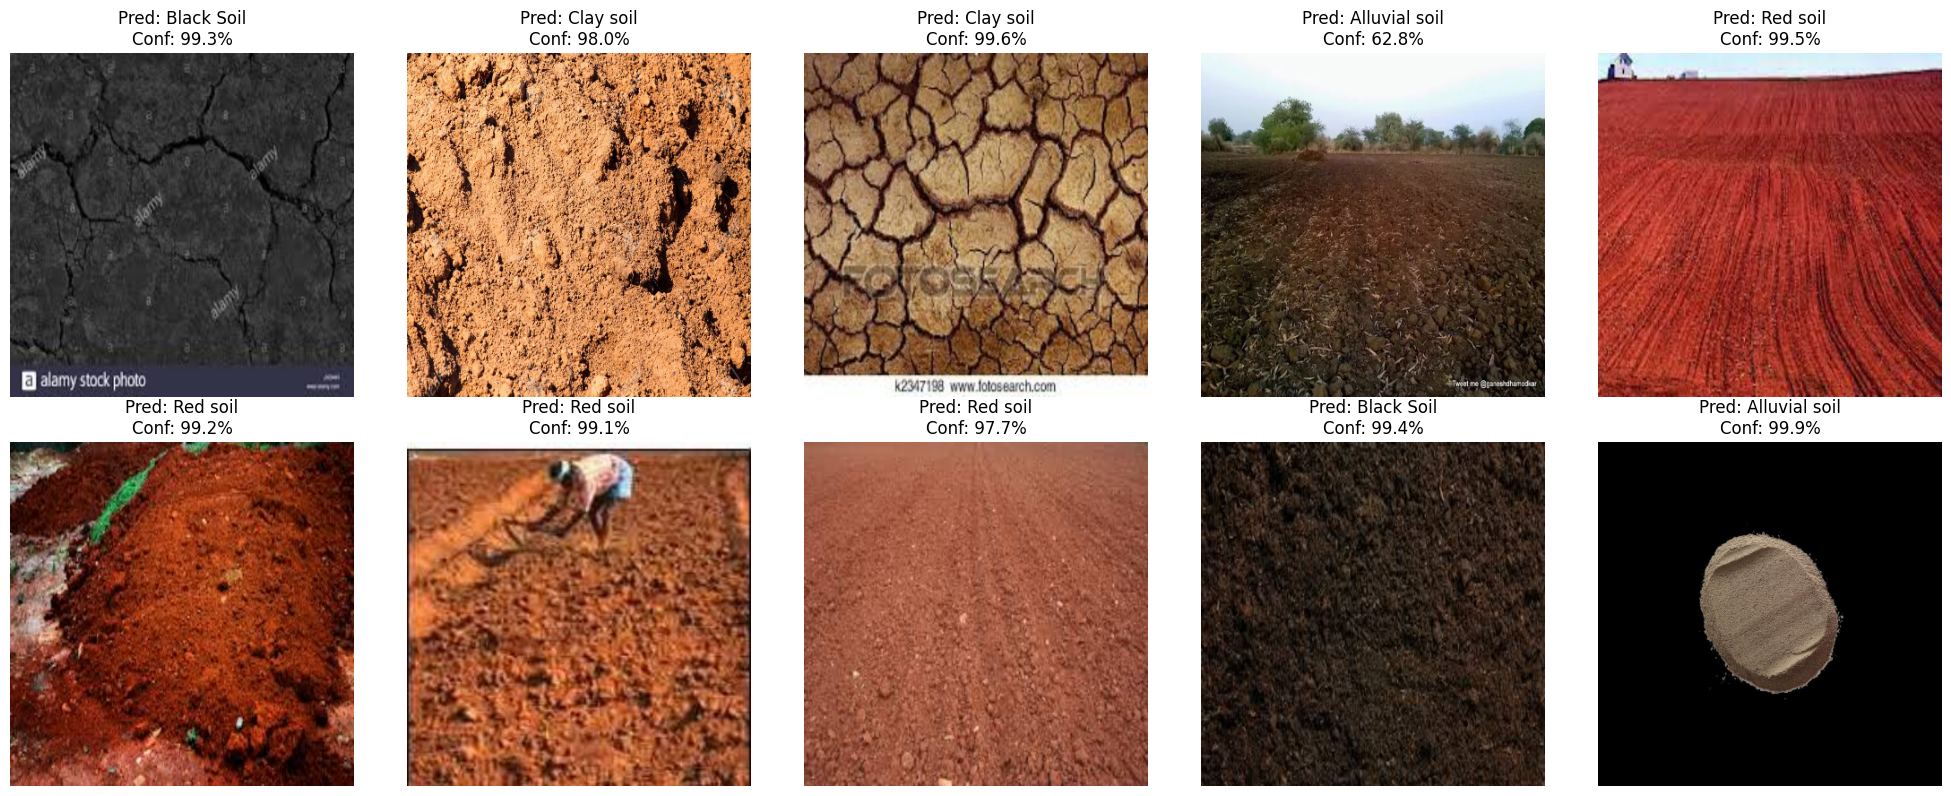

In [22]:
# executing the visualize function
visualize_predictions(best_model, test_df, TEST_DIR)